In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec,KeyedVectors
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from bs4 import BeautifulSoup
import gensim
from sklearn.model_selection import train_test_split
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
import kerastuner as kt
import warnings
warnings.filterwarnings('ignore')

# **Exploring the data**

In [2]:
df = pd.read_csv(r'Data\all_kindle_review .csv')

In [3]:
df.head()

Unnamed: 0.1  Unnamed: 0        asin  helpful  rating  \
0             0       11539  B0033UV8HI  [8, 10]       3   
1             1        5957  B002HJV4DE   [1, 1]       5   
2             2        9146  B002ZG96I4   [0, 0]       3   
3             3        7038  B002QHWOEU   [1, 3]       3   
4             4        1776  B001A06VJ8   [0, 1]       4   

                                          reviewText   reviewTime  \
0  Jace Rankin may be short, but he's nothing to ...   09 2, 2010   
1  Great short read.  I didn't want to put it dow...   10 8, 2013   
2  I'll start by saying this is the first of four...  04 11, 2014   
3  Aggie is Angela Lansbury who carries pocketboo...   07 5, 2014   
4  I did not expect this type of book to be in li...  12 31, 2012   

       reviewerID  reviewerName                   summary  unixReviewTime  
0  A3HHXRELK8BHQG        Ridley  Entertaining But Average      1283385600  
1  A2RGNZ0TRF578I  Holly Butler   Terrific menage scenes!      1381190400  
2  A3S0H2HV6U1I7F       Merissa          Snapdragon Alley      1397174400  
3   AC4OQW3GZ919J    Cleargrace    very light murder cozy      1404518400  
4  A3C9V987IQHOQD      Rjostler                      Book      1356912000

In [4]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'asin', 'helpful', 'rating', 'reviewText',
       'reviewTime', 'reviewerID', 'reviewerName', 'summary',
       'unixReviewTime'],
      dtype='object')

In [5]:
df = df[['reviewText','rating']]

In [6]:
df.shape

(12000, 2)

In [7]:
df.isna().sum()

reviewText    0
rating        0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  12000 non-null  object
 1   rating      12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [10]:
df['rating'] = df['rating'].apply(lambda x: 0 if x<3 else 1)

# **Cleaning and Pre-processing of the Data**

In [11]:
df['reviewText'] = df['reviewText'].str.lower()

In [12]:
# Cleaning using Regular expression
def clean_text(text):
    # Removing Special Characters
    text = re.sub('[^a-zA-z0-9]+',' ',text)
    # Removing URL
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text)
    # Removing html tags
    text = BeautifulSoup(text,'lxml').get_text()
    return text

In [13]:
df['reviewText'] = df['reviewText'].apply(clean_text)

**Removing the stopwords**

In [14]:
def pre_processing_text(text):
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)

    return text


In [15]:
df['reviewText'] = df['reviewText'].apply(pre_processing_text)

In [16]:
df.reviewText[0]

'jace rankin may short nothing mess man hauled saloon undertaker knows famous bounty hunter oregon 1890s shot man saloon finished years long quest avenge sister murder trying figure next snotty nosed farm boy rescued gang bullies offers money kill man forced ranch reluctantly agrees bring man justice kill outright first needs tell sister widower news kyla kyle springer bailey riding trails sleeping ground past month trying find jace wants revenge man killed husband took ranch amongst crimes keen detour jace wants take realizes options hides behind boy persona best tries keep pace confrontation along way gets shot jace discovers kyle kyla come clean whole reason needs scoundrel dead hope still help book share touching moments slow blooming romance kyla find good reason fear men hide behind boy persona watching jace slowly pull shell help conquer fears endearing pain real deeply rooted disappear face sexiness neither understandable aversion marriage magically disappear round nookie would

**Converting Sentences to Tokens**

In [17]:
tokens = []

for sent in df['reviewText']:
    sent_token = sent_tokenize(sent)
    for word in sent_token:
        tokens.append(simple_preprocess(word))

In [18]:
tokens[0]

['jace',
 'rankin',
 'may',
 'short',
 'nothing',
 'mess',
 'man',
 'hauled',
 'saloon',
 'undertaker',
 'knows',
 'famous',
 'bounty',
 'hunter',
 'oregon',
 'shot',
 'man',
 'saloon',
 'finished',
 'years',
 'long',
 'quest',
 'avenge',
 'sister',
 'murder',
 'trying',
 'figure',
 'next',
 'snotty',
 'nosed',
 'farm',
 'boy',
 'rescued',
 'gang',
 'bullies',
 'offers',
 'money',
 'kill',
 'man',
 'forced',
 'ranch',
 'reluctantly',
 'agrees',
 'bring',
 'man',
 'justice',
 'kill',
 'outright',
 'first',
 'needs',
 'tell',
 'sister',
 'widower',
 'news',
 'kyla',
 'kyle',
 'springer',
 'bailey',
 'riding',
 'trails',
 'sleeping',
 'ground',
 'past',
 'month',
 'trying',
 'find',
 'jace',
 'wants',
 'revenge',
 'man',
 'killed',
 'husband',
 'took',
 'ranch',
 'amongst',
 'crimes',
 'keen',
 'detour',
 'jace',
 'wants',
 'take',
 'realizes',
 'options',
 'hides',
 'behind',
 'boy',
 'persona',
 'best',
 'tries',
 'keep',
 'pace',
 'confrontation',
 'along',
 'way',
 'gets',
 'shot',
 '

**Loading the Google Word2Vec Model**

In [19]:
# Loading the Google Word2Vec Model
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [20]:
len(wv.index_to_key)

3000000

In [21]:

# Function to compute the average Word2Vec for a sentence
def avg_word2vec(sentence, model, vector_size=300):
    word_vectors = []
    
    for word in sentence:
        if word in model:  # Only include words that are in the Word2Vec model
            word_vectors.append(model[word])
    
    if len(word_vectors) > 0:
        # Return the average of the word vectors for the sentence
        return np.mean(word_vectors, axis=0)
    else:
        # If the sentence has no words in the Word2Vec model, return a zero vector
        return np.zeros(vector_size)


In [22]:
len(tokens)

12000

In [23]:
# Initialize an empty list to hold the average vectors for each sentence
X = []

# Loop through each tokenized sentence
for sentence in tokens:
    X.append(avg_word2vec(sentence, wv))

In [24]:
X

[array([ 0.07972659,  0.06670273, -0.00345189,  0.04716072, -0.04392486,
         0.01766367,  0.04495446, -0.0649507 ,  0.08383588,  0.08623447,
         0.02615722, -0.11419884, -0.02735664,  0.03717059, -0.09890563,
         0.06791431,  0.0333899 ,  0.11597314,  0.0249468 , -0.06935516,
         0.00368021,  0.05011742,  0.03506342, -0.00839953,  0.0374701 ,
        -0.0702794 , -0.06956939,  0.069074  ,  0.0549709 , -0.02739034,
        -0.01907124,  0.00872753, -0.0229807 ,  0.03502368,  0.01248733,
        -0.00253279,  0.08051787, -0.01898543,  0.01986949,  0.08935602,
         0.08855689, -0.06700297,  0.11170968, -0.01441449, -0.01401441,
        -0.03824089, -0.0503728 ,  0.01025167,  0.02832643,  0.0065222 ,
        -0.05542056,  0.02822861, -0.0107969 , -0.04267802,  0.01284895,
        -0.00349517, -0.05087187, -0.08430081,  0.0275469 , -0.07311296,
         0.01581604,  0.09683529, -0.03772308, -0.06791937, -0.01749929,
        -0.00129781, -0.02329357,  0.03986516, -0.0

In [25]:
X_new = np.array(X)

In [26]:
X_new.shape

(12000, 300)

In [27]:
new_df = pd.DataFrame(X_new)

In [28]:
new_df.head()

0         1         2         3         4         5         6    \
0  0.079727  0.066703 -0.003452  0.047161 -0.043925  0.017664  0.044954   
1  0.055394  0.047289 -0.028312  0.088135 -0.032600 -0.058843  0.065910   
2  0.026984  0.026814  0.001428  0.092755 -0.034156 -0.002335 -0.006825   
3  0.092745  0.029931  0.042697  0.074438 -0.053141  0.045766  0.089922   
4  0.042953  0.053492 -0.037432  0.141052 -0.001160 -0.030052  0.145020   

        7         8         9    ...       290       291       292       293  \
0 -0.064951  0.083836  0.086234  ... -0.059513  0.030273 -0.104615 -0.001711   
1 -0.022064  0.066624  0.108026  ... -0.065106  0.065607 -0.094938  0.017009   
2 -0.054290  0.085555  0.048329  ... -0.064177  0.046609 -0.098504 -0.026998   
3  0.019759  0.060217  0.096253  ... -0.106100 -0.019124 -0.073299  0.027773   
4  0.000656  0.084297  0.040771  ... -0.036285  0.038158 -0.070282  0.000774   

        294       295       296       297       298       299  
0 -0.049679 -0.026528  0.022833 -0.059434  0.038598  0.015042  
1 -0.083922 -0.035948  0.035835 -0.045622 -0.005624 -0.034167  
2  0.008329 -0.043711 -0.002262 -0.009868  0.005976 -0.028655  
3 -0.048280 -0.084399  0.022961 -0.057578  0.035518  0.042843  
4  0.108490 -0.028992  0.062061  0.017662  0.054092 -0.048580  

[5 rows x 300 columns]

# **Training The Artificial Neural Networks**

In [29]:
X = new_df
y = df['rating']

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [31]:
y_test

1935     1
6494     0
1720     0
9120     0
360      0
        ..
1195     1
11877    1
5421     1
3855     1
4414     1
Name: rating, Length: 2400, dtype: int64

In [44]:
model = Sequential()

In [45]:
model.add(Dense(128,activation='relu',input_dim=300))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))  # nodes must be equal to the class

In [46]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test))

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6943 - loss: 0.5657 - val_accuracy: 0.8033 - val_loss: 0.4091
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8144 - loss: 0.4115 - val_accuracy: 0.8092 - val_loss: 0.3972
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8173 - loss: 0.4043 - val_accuracy: 0.8150 - val_loss: 0.3937
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8241 - loss: 0.3957 - val_accuracy: 0.8117 - val_loss: 0.4018
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8307 - loss: 0.3814 - val_accuracy: 0.8208 - val_loss: 0.3889
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8373 - loss: 0.3657 - val_accuracy: 0.8150 - val_loss: 0.3957
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8484 - loss: 0.3525 - val_accuracy: 0.8208 - val_loss: 0.3952
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8443 - loss: 0.3595 - val_accuracy: 0.

<Axes: >

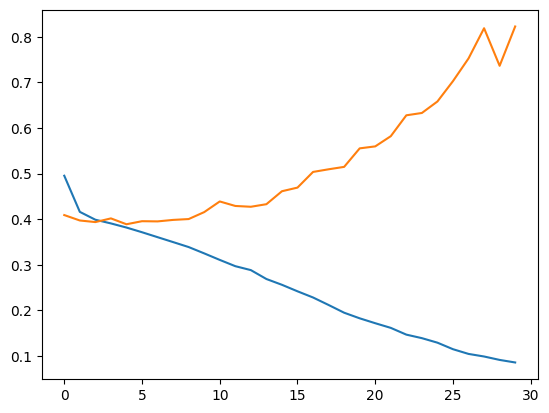

In [48]:
sns.lineplot(history.history['loss'])
sns.lineplot(history.history['val_loss'])

<Axes: >

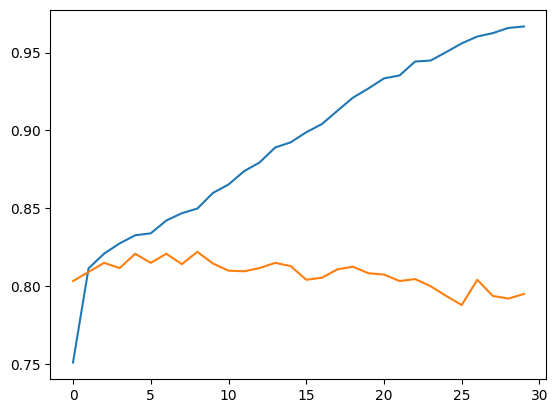

In [49]:
sns.lineplot(history.history['accuracy'])
sns.lineplot(history.history['val_accuracy'])

# **Hyper-parameter Tunning of ANN** 

In [78]:
def build_model(hp):
    model = Sequential()

    counter = 0

    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        if counter==0:
            model.add(
                Dense(
                    hp.Int('units'+str(i),min_value=8,max_value=128,step=8),
                    activation= hp.Choice('activation'+str(i),values = ['relu','tanh','sigmoid']),
                    input_dim =300
                    )
                ) 
            model.add(Dropout(hp.Choice('dropout' + str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
            model.add(
                Dense(
                    hp.Int('units'+str(i),min_value=8,max_value=128,step=8),
                    activation= hp.Choice('activation'+str(i),values = ['relu','tanh','sigmoid'])
                    )
                ) 
            model.add(Dropout(hp.Choice('dropout' + str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        counter+=1 
    model.add(Dense(1,activation='sigmoid'))

    model.compile(
                    optimizer=hp.Choice('optimizer',
                    values=['rmsprop','adam','sgd','nadam','adadelta']),
                    loss='binary_crossentropy',metrics=['accuracy']
                )

    return model



In [79]:
tunner = kt.RandomSearch(
                        build_model,objective='val_accuracy',
                         max_trials=5,directory = 'my_dir',
                         project_name = 'kindle_sentiment_analysis'
                         )

In [80]:
tunner.search(X_train,y_train,epochs = 5, validation_data=(X_test,y_test))

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.6654166579246521

Best val_accuracy So Far: 0.8208333253860474
Total elapsed time: 00h 00m 28s


In [81]:
tunner.get_best_hyperparameters()[0].values

{'num_layers': 2,
 'units0': 80,
 'activation0': 'tanh',
 'dropout0': 0.5,
 'optimizer': 'adam',
 'units1': 64,
 'activation1': 'relu',
 'dropout1': 0.7,
 'units2': 64,
 'activation2': 'sigmoid',
 'dropout2': 0.5,
 'units3': 32,
 'activation3': 'tanh',
 'dropout3': 0.2,
 'units4': 16,
 'activation4': 'tanh',
 'dropout4': 0.1,
 'units5': 80,
 'activation5': 'sigmoid',
 'dropout5': 0.1,
 'units6': 56,
 'activation6': 'sigmoid',
 'dropout6': 0.4,
 'units7': 8,
 'activation7': 'relu',
 'dropout7': 0.8,
 'units8': 24,
 'activation8': 'tanh',
 'dropout8': 0.7}

In [82]:
model = tunner.get_best_models(num_models=1)[0]

In [83]:
history = model.fit(X_train,y_train,epochs=100,initial_epoch=5,validation_data=(X_test,y_test))

Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8171 - loss: 0.4232 - val_accuracy: 0.8196 - val_loss: 0.3920
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8104 - loss: 0.4187 - val_accuracy: 0.8183 - val_loss: 0.3921
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8183 - loss: 0.4248 - val_accuracy: 0.8179 - val_loss: 0.3906
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8240 - loss: 0.4126 - val_accuracy: 0.8008 - val_loss: 0.4155
Epoch 10/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8225 - loss: 0.4053 - val_accuracy: 0.8183 - val_loss: 0.3893
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8222 - loss: 0.4150 - val_accuracy: 0.8167 - val_loss: 0.3878
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.4066 - val_accuracy: 0.8229 - val_loss: 0.3840
Epoch 13/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8285 - loss: 0.3894 - val_

In [99]:
# Accessing accuracy and loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print the final training and validation accuracy
print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


Final Training Accuracy: 0.8322
Final Validation Accuracy: 0.8167


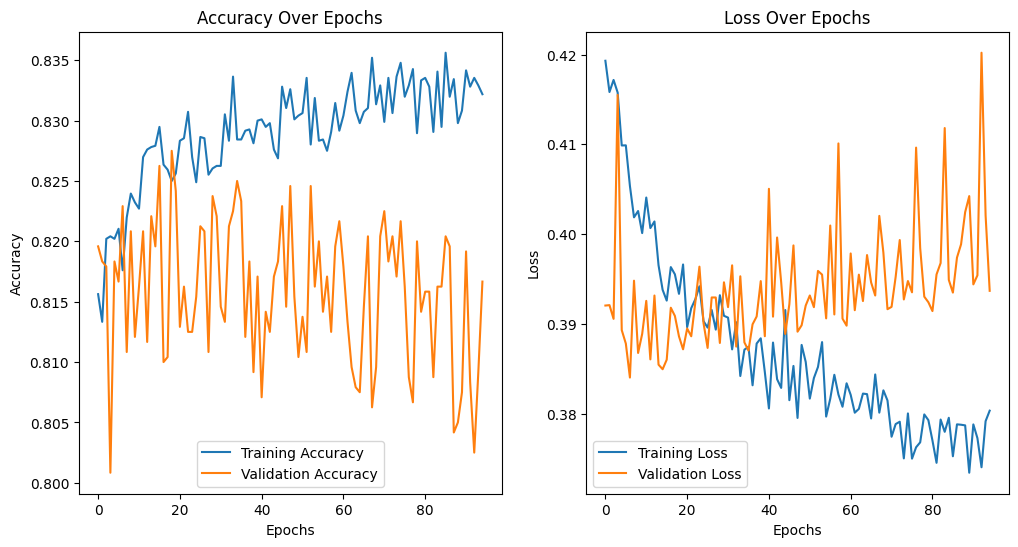

In [100]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [105]:
# Save the model in Keras format
model.save('my_model.keras')

# **Thank You**